# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/MyDrive/cs445_proj2_starter_code/cs445_proj2_starter_code-2/"
utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [4]:
import random
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output_image = np.zeros((out_size, out_size, 3))
    height, width, _ = sample.shape
    number_patch = out_size // patch_size
    row = height - patch_size
    column = width - patch_size
    for i in range(number_patch):
      for j in range(number_patch):
        temp_h = random.randint(0, row)
        temp_w = random.randint(0, column)
        row_start = i * patch_size
        row_end = (i+1) * patch_size
        col_start = j * patch_size
        col_end = (j+1) * patch_size
        slice_b = sample[temp_h:temp_h+patch_size, temp_w:temp_w+patch_size,:]
        output_image[row_start:row_end,col_start:col_end,:] = slice_b.copy()
    return output_image



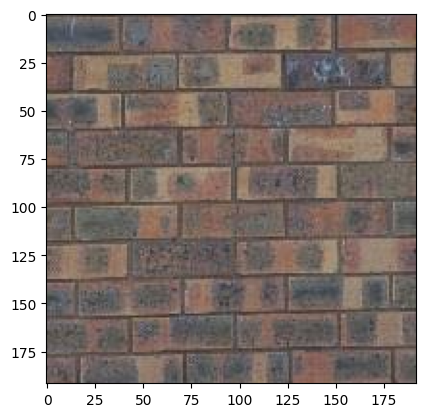

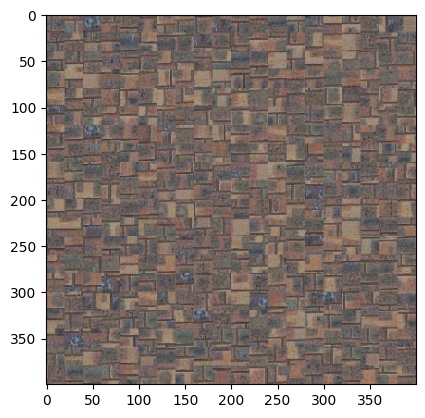

In [5]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()
out_size = 400
patch_size = 20

res = quilt_random(sample_img, out_size, patch_size)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

### Part II: Overlapping Patches (30 pts)

In [6]:
def ssd(T, M, I):
  T = T.astype(np.float64) / 15
  I = I.astype(np.float64) / 15
  M = M.astype(np.float64)
  channels = [0, 1, 2]
  ssd = sum([((M[:,:,ch] * T[:,:,ch])**2).sum() -
               2 * cv2.filter2D(I[:,:,ch], ddepth=-1, kernel = M[:,:,ch] * T[:,:,ch]) +
               cv2.filter2D(I[:,:,ch] ** 2, ddepth=-1, kernel=M[:,:,ch]) for ch in channels])
  return np.absolute(ssd)
def choose_sample(cost_image, tol):
  min_cost = np.min(cost_image)
  row, col = np.where(cost_image <= min_cost * (1+tol))
  if len(row) == 0:
    raise ValueError("No valid samples found.")
  index = np.random.choice(len(row))
  row_index = row[index]
  col_index = col[index]
  return row_index, col_index
def generate_block(sample, patch_size, temp_h, temp_w):
    return sample[temp_h:temp_h+patch_size, temp_w:temp_w+patch_size, :].copy()

def update_block(output_image, sample, mask, patch_size, overlap, tol, row_index, col_index, start_r, end_r, start_c, end_c):
    template = output_image[start_r:end_r, start_c:end_c, :]
    ssd_image = ssd(mask, template, sample)
    new_p = patch_size // 2
    ssd_image = ssd_image[new_p:-new_p, new_p:-new_p]
    row_idx, col_idx = choose_sample(ssd_image, tol)
    output_image[start_r:end_r, start_c:end_c, :] = generate_block(sample, patch_size, row_idx, col_idx)

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    output_image = np.zeros((out_size, out_size, 3))
    mask_top_left = np.zeros((patch_size, patch_size, 3))
    mask_top = np.zeros((patch_size, patch_size, 3))
    mask_left = np.zeros((patch_size, patch_size, 3))
    mask_left[:overlap, :, :] = 1
    mask_top[:, :overlap, :] = 1
    mask_top_left[:overlap, :, :] = 1
    mask_top_left[:, :overlap, :] = 1
    height, width, _ = sample.shape
    row = (out_size - overlap) // (patch_size - overlap)
    col = (out_size - overlap) // (patch_size - overlap)
    temp_h = random.randint(0, height - patch_size)
    temp_w = random.randint(0, width - patch_size)
    output_image[:patch_size, :patch_size, :] = generate_block(sample, patch_size, temp_h, temp_w)
    for i in range(1, row):
      start_r = i * (patch_size - overlap)
      end_r = start_r + patch_size
      update_block(output_image, sample, mask_top, patch_size, overlap, tol,
                    row_index=None, col_index=None, start_r=start_r, end_r=end_r, start_c=0, end_c=patch_size)
    for j in range(1, col):
      start_c = j * (patch_size - overlap)
      end_c = start_c + patch_size
      update_block(output_image, sample, mask_left, patch_size, overlap, tol,
                    row_index=None, col_index=None, start_r=0, end_r=patch_size, start_c=start_c, end_c=end_c)
    for i in range(1, row):
        for j in range(1, col):
          start_r = i * (patch_size - overlap)
          end_r = start_r + patch_size
          start_c = j * (patch_size - overlap)
          end_c = start_c + patch_size
          update_block(output_image, sample, mask_top_left, patch_size, overlap, tol,
                        row_index=None, col_index=None, start_r=start_r, end_r=end_r, start_c=start_c, end_c=end_c)
    return output_image

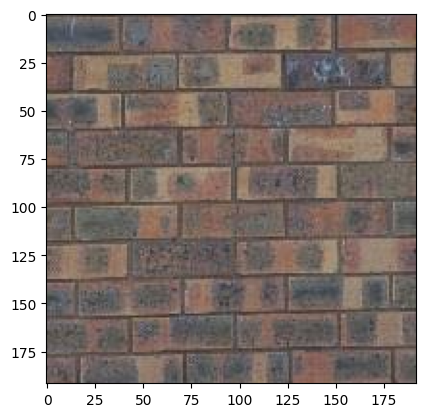

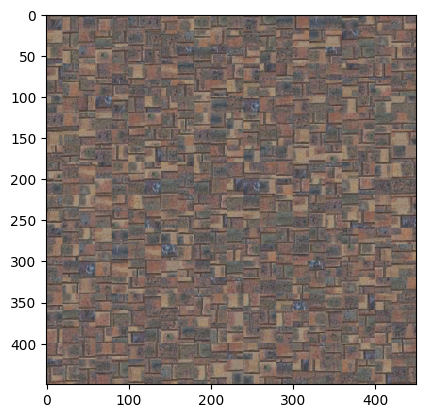

In [7]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()
out_size = 450
patch_size = 30
overlap = 10
tol = 10
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

### Part III: Seam Finding (20 pts)


In [8]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [9]:
def get_new_patch(template, mask, sample, patch_size):
  ssd1 = ssd(template, mask, sample)
  ssd1 = ssd1[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  row_index, col_index = choose_sample(ssd1, tol)
  new_patch = generate_block(sample, patch_size, row_index, col_index)
  return new_patch

def quilt_cut(sample, out_size, patch_size, overlap, tol):
  mask_left = np.zeros((patch_size, patch_size, 3))
  mask_left[:,:overlap,:] = 1
  mask_top = np.zeros((patch_size, patch_size, 3))
  mask_top[:overlap,:,:] = 1
  mask_top_left = np.zeros((patch_size, patch_size, 3))
  mask_top_left[:,:overlap,:] = 1
  mask_top_left[:overlap,:,:] = 1
  output_image = np.zeros((out_size, out_size, 3))
  rows = (out_size-overlap) // (patch_size-overlap)
  cols = (out_size-overlap) // (patch_size-overlap)
  height, width, _ = sample.shape
  temp_h = random.randint(0, height-patch_size)
  temp_w = random.randint(0, width-patch_size)
  output_image[:patch_size, :patch_size, :] = generate_block(sample, patch_size, temp_h, temp_w)
  for i in range(1, rows):
    template = output_image[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, : patch_size, :]
    new_patch = get_new_patch(template, mask_top, sample, patch_size)
    diff = template[:overlap,: patch_size, :]**2 - new_patch[:overlap, :patch_size, :]**2
    diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
    path = cut(diff)
    path = path.astype(np.uint8)
    inv_path = np.ones(path.shape)-path
    for j in range(3):
      new_patch[:overlap,:patch_size,j] *= path
      template[:overlap,:patch_size,j] *= inv_path
    template += new_patch
  for i in range(1, cols):
    template = output_image[:patch_size, i*(patch_size-overlap):i*(patch_size-overlap)+patch_size,:]
    new_patch = get_new_patch(template, mask_left, sample, patch_size)
    diff = template[: patch_size,:overlap, :]**2 - new_patch[:patch_size,:overlap, :]**2
    diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
    path = cut(diff)
    path = path.astype(np.uint8)
    inv_path = np.ones(path.shape)-path
    for j in range(3):
      new_patch[:patch_size,:overlap, j]*=path
      template[:patch_size,:overlap,j] *=inv_path
    template += new_patch
  for i in range(1, rows):
    for j in range(1, cols):
      template = output_image[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, \
                              j*(patch_size-overlap):j*(patch_size-overlap)+patch_size, :]
      new_patch = get_new_patch(template, mask_top_left, sample, patch_size)
      diff = template[:overlap,: patch_size, :]**2 - new_patch[:overlap, :patch_size, :]**2
      diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
      path1 = cut(diff)
      diff = template[: patch_size,:overlap, :]**2 - new_patch[:patch_size,:overlap, :]**2
      diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
      path2 = cut(diff)
      path_combined = np.ones((patch_size, patch_size))
      path_combined[:overlap,:patch_size] *= path1
      path_combined[:patch_size,:overlap] *= path2
      path_combined = path_combined.astype(np.uint8)
      inv_mask = np.ones(path_combined.shape)-path_combined
      for z in range(3):
        new_patch[:,:,z] *= path_combined
        template[:, :,z] *= inv_mask
      template += new_patch
  return output_image

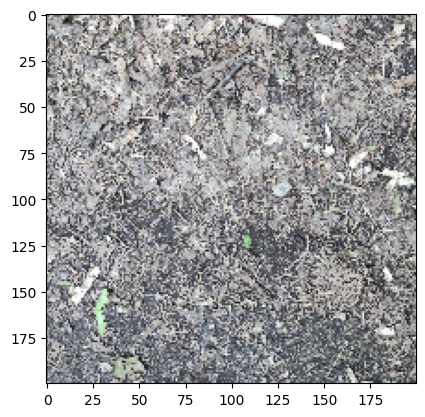

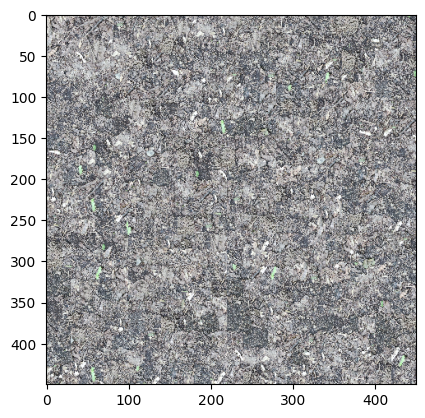

In [82]:
sample_img_fn = 'samples/land.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
resize_sample = cv2.resize(sample_img, (200,200))
plt.imshow(resize_sample)
plt.show()
out_size = 450
patch_size = 30
overlap = 10
tol = 5
res = quilt_cut(resize_sample, out_size, patch_size, overlap, tol)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

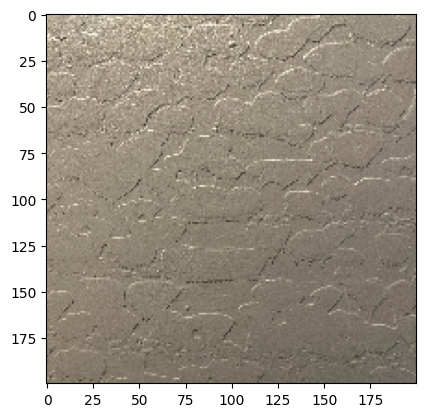

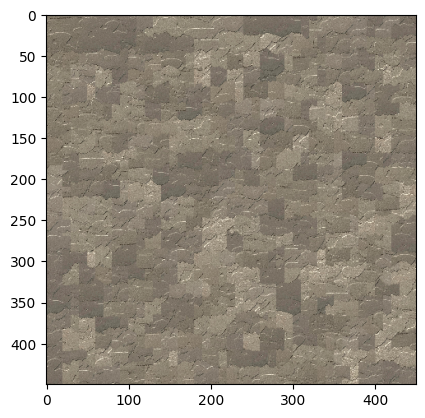

In [83]:
sample_img_fn = 'samples/liquid.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
resize_sample = cv2.resize(sample_img, (200,200))
plt.imshow(resize_sample)
plt.show()
out_size = 450
patch_size = 30
overlap = 10
tol = 5
res = quilt_cut(resize_sample, out_size, patch_size, overlap, tol)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

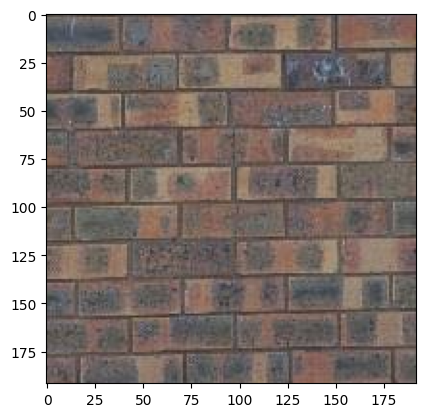

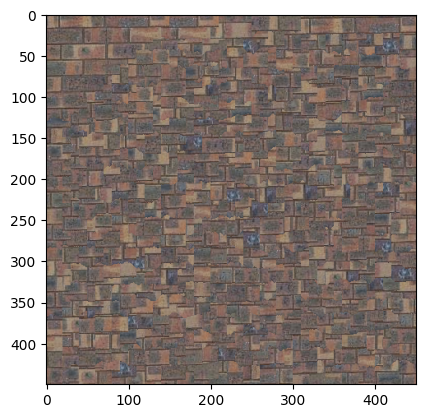

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()
out_size = 450
patch_size = 30
overlap = 10
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

In [41]:
def visualize(template, new_patch, patch_size, overlap, path, diff, flag):
  fig, axes = plt.subplots(1,3)
  if flag == -1:
    axes[0].imshow(cv2.cvtColor(template[:patch_size,:overlap, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(cv2.cvtColor(new_patch[:patch_size,:overlap, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[1].set_xticks([])
    axes[1].set_yticks([])
  elif flag == 1:
    axes[0].imshow(cv2.cvtColor(template[:overlap,:patch_size, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(cv2.cvtColor(new_patch[:overlap, :patch_size, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[1].set_xticks([])
    axes[1].set_yticks([])
  else:
    axes[0].imshow(cv2.cvtColor(template[:patch_size,:overlap, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(cv2.cvtColor(new_patch[:patch_size,:overlap, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[1].set_xticks([])
    axes[1].set_yticks([])
  y, x = np.where(path)
  axes[2].imshow(np.absolute(diff/255).astype(np.uint8), cmap='gray')
  axes[2].plot(x, y, '-', linewidth=2, color='firebrick')
  axes[2].set_xticks([])
  axes[2].set_yticks([])

In [76]:
def plot_function(sample, out_size, patch_size, overlap, tol):
  mask_left = np.zeros((patch_size, patch_size, 3))
  mask_left[:,:overlap,:] = 1
  mask_top = np.zeros((patch_size, patch_size, 3))
  mask_top[:overlap,:,:] = 1
  mask_top_left = np.zeros((patch_size, patch_size, 3))
  mask_top_left[:,:overlap,:] = 1
  mask_top_left[:overlap,:,:] = 1
  print("mask_left:", mask_left)
  print("mask_top:", mask_top)
  print("mask_combine:", mask_top_left)
  # left
  output_image = np.zeros((out_size, out_size, 3))
  height, width, _ = sample.shape
  temp_h = random.randint(0, height-patch_size)
  temp_w = random.randint(0, width-patch_size)
  output_image[:patch_size, :patch_size, :] = generate_block(sample, patch_size, temp_h, temp_w)
  template_left = output_image[:patch_size,:patch_size,:]
  new_patch_left = get_new_patch(template_left, mask_left, sample, patch_size)
  diff_left = template_left[:patch_size,:overlap,:]**2 - new_patch_left[:patch_size,:overlap,:]**2
  diff_left = diff_left.sum(axis=2)
  path_left = cut(diff_left)
  flag = -1
  visualize(template_left, new_patch_left, patch_size, overlap, path_left, diff_left, flag)
  # top
  output_image[:patch_size, :patch_size, :] = generate_block(sample, patch_size, temp_h, temp_w)
  template_top = output_image[:patch_size, :patch_size,:]
  new_patch_top = get_new_patch(template_top, mask_top, sample, patch_size)
  diff_top = template_top[:overlap,:patch_size,:]**2 - new_patch_top[:overlap,:patch_size,:]**2
  diff_top = diff_top.sum(axis=2)
  path_top = cut(diff_top)
  flag = 1
  visualize(template_top, new_patch_top, patch_size, overlap, path_top, diff_top, flag)
  # combine
  flag = 0
  output_image[:patch_size, :patch_size, :] = generate_block(sample, patch_size, temp_h, temp_w)
  template_combine = output_image[:patch_size,:patch_size,:]
  new_patch_combine = get_new_patch(template_combine, mask_top_left, sample, patch_size)
  diff1 = template_combine[:overlap, :patch_size,:]**2 - new_patch_combine[:overlap,:patch_size,:]**2
  diff1 = diff1.sum(axis=2)
  diff2 = template_combine[:patch_size, :overlap, :]**2 - new_patch_combine[:patch_size,:overlap,:]**2
  diff2 = diff2.sum(axis=2)
  diff_combined = np.zeros((patch_size, patch_size))
  diff_combined[:overlap,:] += diff1
  diff_combined[:,:overlap] += diff2
  path_combined = np.ones((patch_size, patch_size))
  path_combined[:overlap, :] *= cut(diff1)
  path_combined[:, :overlap] *= cut(diff2)
  visualize(template_combine, new_patch_combine, patch_size, overlap, path_combined, diff_combined, flag)

mask_left: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
mask_top: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0.

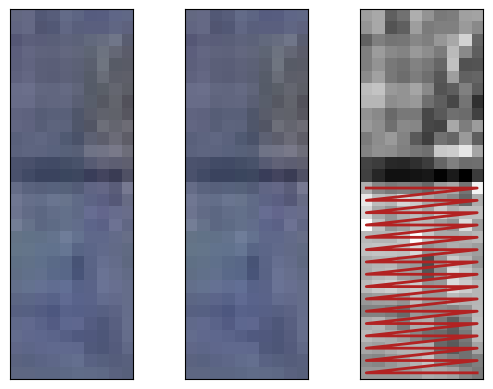

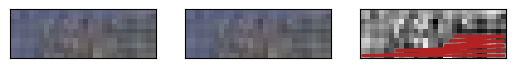

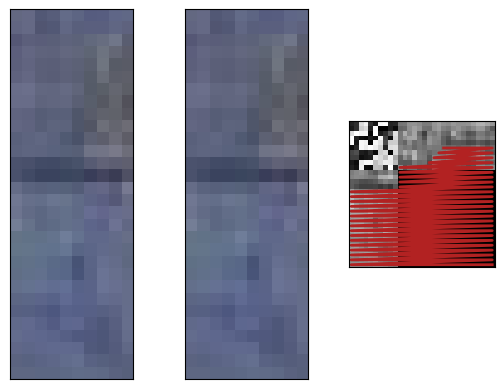

In [77]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
out_size = 450
patch_size = 30
overlap = 10
tol = 5
res = plot_function(sample_img, out_size, patch_size, overlap, tol)

### part IV: Texture Transfer (30 pts)

In [84]:
def compute_patch(template, mask, sample, target_patch, alpha, patch_size, overlap):
  ones = np.ones((patch_size, patch_size, 3))
  ssd_overlap = ssd(template, mask, sample)
  ssd_target = ssd(target_patch, ones, sample)
  ssd_overlap = ssd_overlap[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  ssd_target = ssd_target[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  (row, col) = choose_sample(ssd_overlap*alpha+ssd_target*(1-alpha), tol)
  new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
  return new_patch
def combined_mask(replace_top, replace_left, new_patch, overlap):
  ones1 = np.ones((overlap, new_patch.shape[1]))
  ones2 = np.ones((new_patch.shape[0], overlap))
  diff1 = (replace_top - new_patch[:overlap, :]).sum(axis=2)
  mask1 = cut(diff1)
  diff2 = (replace_left - new_patch[:, :overlap]).sum(axis=2)
  mask2 = cut(diff2)
  mask_combined = np.ones((new_patch.shape[0], new_patch.shape[1]))
  mask_combined[:overlap, :] *= mask1
  mask_combined[:, :overlap] *= mask2
  return mask_combined.astype(np.uint8)

def apply_combined_mask(mask, new_patch, template):
  mask = cut(mask).astype(np.uint8)
  inv_mask = 1 - mask
  for ch in range(3):
    new_patch[:,:,ch] *= mask
    template[:,:,ch] *= inv_mask
  template += new_patch
  return template
def apply_mask(mask, new_patch, template, flag, patch_size, overlap):
  mask = cut(mask).astype(np.uint8)
  inv_mask = 1 - mask
  if flag == 1:
    for ch in range(3):
      new_patch[:overlap,:patch_size,ch] *= mask
      template[:overlap,:patch_size,ch] *= inv_mask
    template += new_patch
  else:
    for ch in range(3):
      new_patch[:patch_size,:overlap,ch] *= mask
      template[:patch_size,:overlap,ch] *= inv_mask
    template += new_patch
  return template
def texture_transfer(sample, patch_size, overlap, tol, guidance_img, alpha):
  height, width, _ = guidance_img.shape
  mask_left = np.zeros((patch_size, patch_size, 3))
  mask_left[:, :overlap,:] = 1
  mask_top = np.zeros((patch_size, patch_size, 3))
  mask_top[:overlap, :, :] = 1
  mask_top_left = np.zeros((patch_size, patch_size, 3))
  mask_top_left[:, :overlap, :] = 1
  mask_top_left[:overlap, :, :] = 1
  output_image = np.zeros((height, width, 3))
  rows = (height-overlap) // (patch_size-overlap)
  cols = (width-overlap) // (patch_size-overlap)
  for i in range(rows):
    for j in range(cols):
      y_start, y_end = i*(patch_size-overlap), i*(patch_size-overlap)+patch_size
      x_start, x_end = j*(patch_size-overlap), j*(patch_size-overlap)+patch_size
      replace = output_image[y_start:y_end, x_start:x_end, :]
      target_patch = guidance_img[y_start:y_end, x_start:x_end, :]
      if i == 0 and j == 0:
        mask = np.ones((patch_size, patch_size, 3))
      elif i == 0:
        mask = mask_left
      elif j == 0:
        mask = mask_top
      else:
        mask = mask_top_left
      new_patch = compute_patch(replace, mask, sample, target_patch, alpha, patch_size, overlap)
      if i != 0 and j != 0:
        replace_top = output_image[y_start-overlap:y_start, x_start:x_end, :]
        replace_left = output_image[y_start:y_end, x_start-overlap:x_start, :]
        mask = combined_mask(replace_top, replace_left, new_patch, overlap)
        replace = apply_combined_mask(mask, new_patch, replace)
      elif i != 0:
        diff = replace[:overlap, :, :] - new_patch[:overlap, :, :]
        replace = apply_mask(diff.sum(axis=2), new_patch, replace, 1, patch_size, overlap)
      elif j != 0:
        diff = replace[:, :overlap, :] - new_patch[:, :overlap, :]
        replace = apply_mask(diff.sum(axis=2), new_patch, replace, -1, patch_size, overlap)
      output_image[y_start:y_end, x_start:x_end, :] = replace
  return output_image

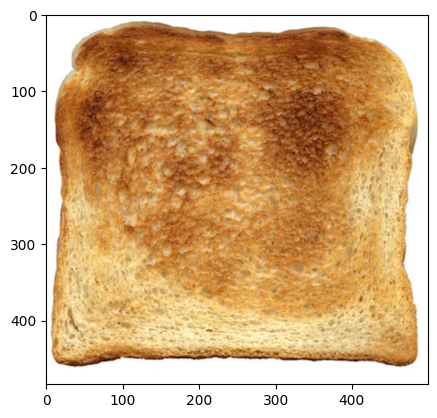

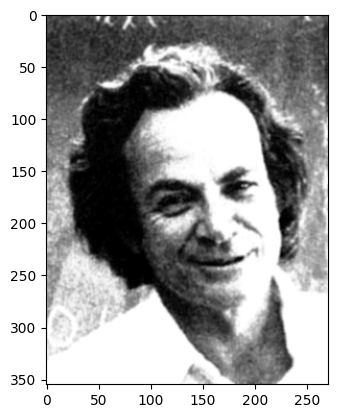

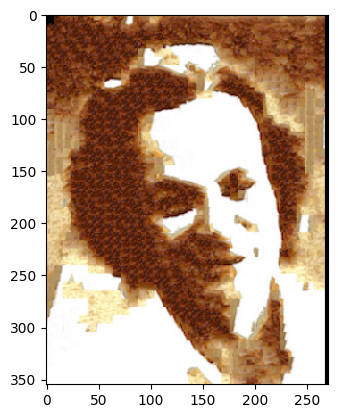

In [85]:
# load/process appropriate input texture and guidance images
texture_img_fn = "samples/toast.jpg"
guidance_img_fn = "samples/feynman.tiff"
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
patch_size = 11
overlap = 3
tol = 0.1
alpha = 0.6
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()


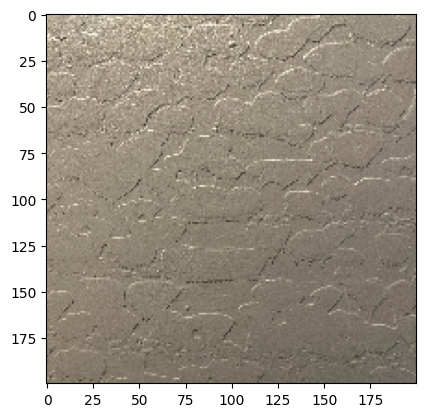

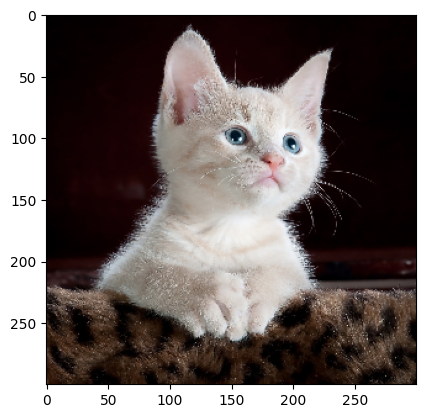

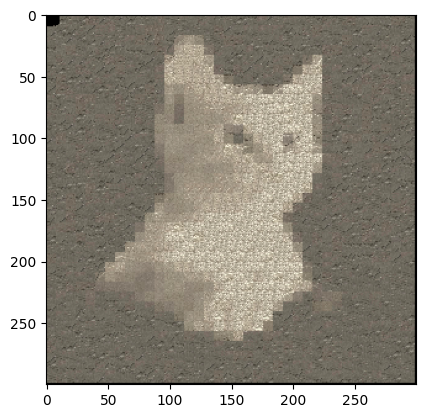

In [92]:
texture_img_fn = "samples/liquid.jpg"
guidance_img_fn = "samples/cat_j.jpg"
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
resize_texture = cv2.resize(texture_img, (200,200))
resize_target = cv2.resize(guidance_img, (300,300))
plt.imshow(resize_texture)
plt.show()
plt.imshow(resize_target)
plt.show()
patch_size = 11
overlap = 3
tol = 0.1
alpha = 0.3
res = texture_transfer(resize_texture, patch_size, overlap, tol, resize_target, alpha)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [95]:
def iterative_texture_transfer(sample, patch_size, overlap, tol, guidance_img, alpha, num_iterations=3, threshold=1e-5):
    output = guidance_img
    prev_output = np.zeros_like(output)
    for _ in range(num_iterations):
        diff = np.linalg.norm(output - prev_output)
        if diff < threshold:
            break
        prev_output = output.copy()
        output = texture_transfer(sample, patch_size, overlap, tol, output, alpha)
    return output

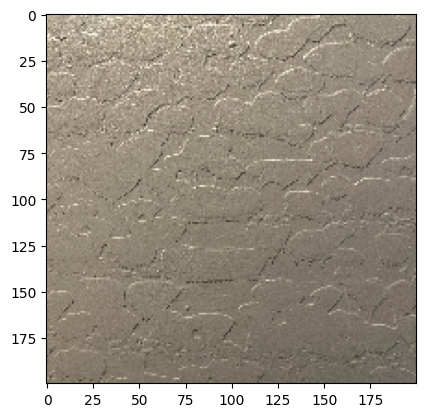

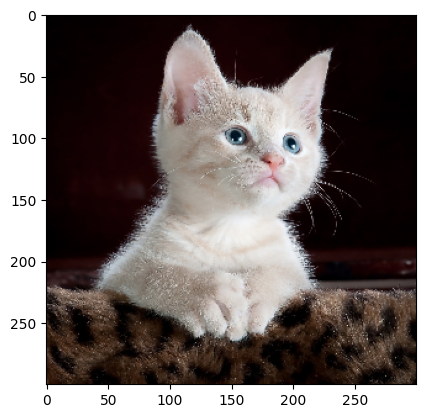

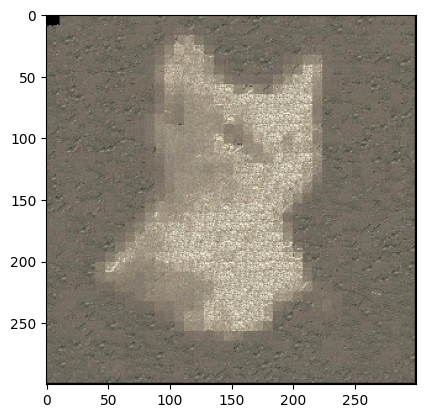

In [96]:
texture_img_fn = "samples/liquid.jpg"
guidance_img_fn = "samples/cat_j.jpg"
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
resize_texture = cv2.resize(texture_img, (200,200))
resize_target = cv2.resize(guidance_img, (300,300))
plt.imshow(resize_texture)
plt.show()
plt.imshow(resize_target)
plt.show()
patch_size = 11
overlap = 3
tol = 0.1
alpha = 0.1
res = iterative_texture_transfer(resize_texture, patch_size, overlap, tol, resize_target, alpha)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

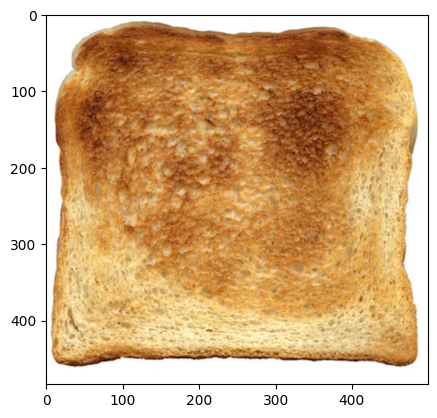

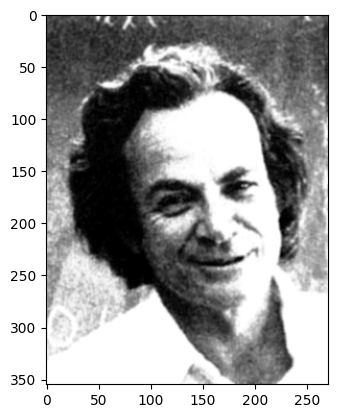

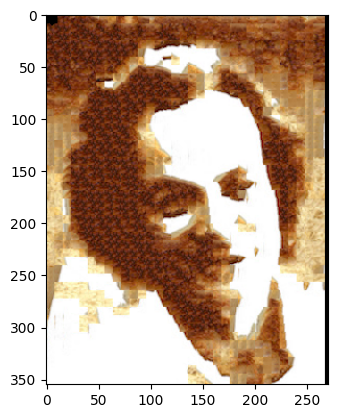

In [99]:
texture_img_fn = "samples/toast.jpg"
guidance_img_fn = "samples/feynman.tiff"
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()
plt.imshow(guidance_img)
plt.show()
patch_size = 11
overlap = 3
tol = 0.1
alpha = 0.2
res = iterative_texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [137]:
def build_gaussian_pyramid(origin, levels):
  temp = origin.copy()
  gaussian_pyramid = [temp]
  for i in range(levels):
    temp = cv2.pyrDown(temp)
    gaussian_pyramid.append(temp)
  return gaussian_pyramid

def build_laplacian_pyramid(origin, levels):
  gaussian_pyramid = build_gaussian_pyramid(origin, levels)
  laplacian_pyramid = [gaussian_pyramid[-1]]
  for i in range(levels, 0, -1):
    temp_lap_up = cv2.pyrUp(gaussian_pyramid[i])
    h, w = gaussian_pyramid[i-1].shape[:2]
    temp_lap_up_resized = temp_lap_up[:h,:w]
    temp_lap = cv2.subtract(gaussian_pyramid[i-1], temp_lap_up_resized)
    laplacian_pyramid.append(temp_lap)
  return laplacian_pyramid

def blend_laplacian_pyramids(L1, L2, mask):
  blended_pyramid = []
  for i in range(len(L1)):
    blended_layer = L1[i]*mask[i] + L2[i] * (1 - mask[i])
    blended_pyramid.append(blended_layer)
  return blended_pyramid

def reconstruct_from_laplacian(blendpyramid):
  reconstructed_image = blendpyramid[0]
  for i in range(1, len(blendpyramid)):
    reconstructed_image = cv2.pyrUp(reconstructed_image)
    # print("blended:", blendpyramid[i].shape)
    reconstructed_image = reconstructed_image[:blendpyramid[i].shape[0], :blendpyramid[i].shape[1]]
    reconstructed_image += blendpyramid[i]
  return reconstructed_image

def laplacian_blending(patch1, patch2, mask, levels=5):
  LPatch1 = build_laplacian_pyramid(patch1, levels)
  LPatch2 = build_laplacian_pyramid(patch2, levels)
  mask_gp = build_laplacian_pyramid(mask, levels)
  # print("Lpatch1:", LPatch1[-1].shape)
  # print("Lpatch2:", LPatch2[-1].shape)
  # print("mask:", mask_gp[0].shape)
  blended_pyramid = blend_laplacian_pyramids(LPatch1, LPatch2, mask_gp)
  result = reconstruct_from_laplacian(blended_pyramid)
  return result

In [138]:
def compute_patch(template, mask, sample, target_patch, alpha, patch_size, overlap):
  ones = np.ones((patch_size, patch_size, 3))
  ssd_overlap = ssd(template, mask, sample)
  ssd_target = ssd(target_patch, ones, sample)
  ssd_overlap = ssd_overlap[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  ssd_target = ssd_target[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  (row, col) = choose_sample(ssd_overlap*alpha+ssd_target*(1-alpha), tol)
  new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
  return new_patch
def texture_transfer2(sample, patch_size, overlap, tol, guidance_img, alpha):
  height, width, _ = guidance_img.shape
  mask_left = np.zeros((patch_size, patch_size, 3))
  mask_left[:, :overlap,:] = 1
  mask_top = np.zeros((patch_size, patch_size, 3))
  mask_top[:overlap, :, :] = 1
  mask_top_left = np.zeros((patch_size, patch_size, 3))
  mask_top_left[:, :overlap, :] = 1
  mask_top_left[:overlap, :, :] = 1
  # print("mask")
  # print(mask_top.shape)
  # print(mask_left.shape)
  output_image = np.zeros((height, width, 3))
  rows = (height-overlap) // (patch_size-overlap)
  cols = (width-overlap) // (patch_size-overlap)
  for i in range(rows):
    for j in range(cols):
      y_start, y_end = i*(patch_size-overlap), i*(patch_size-overlap)+patch_size
      x_start, x_end = j*(patch_size-overlap), j*(patch_size-overlap)+patch_size
      replace = output_image[y_start:y_end, x_start:x_end, :]
      target_patch = guidance_img[y_start:y_end, x_start:x_end, :]
      if i == 0 and j == 0:
          mask = np.ones((patch_size, patch_size, 3))
      elif i == 0:
          mask = mask_left
      elif j == 0:
          mask = mask_top
      else:
          mask = mask_top_left
      new_patch = compute_patch(replace, mask, sample, target_patch, alpha, patch_size, overlap)
      if i != 0 and j != 0:
        replace = laplacian_blending(replace, new_patch, mask_top_left)
      elif i != 0:
        replace = laplacian_blending(replace, new_patch, mask_top)
      elif j != 0:
        replace = laplacian_blending(replace, new_patch, mask_left)
      output_image[y_start:y_end, x_start:x_end, :] = replace
  return output_image

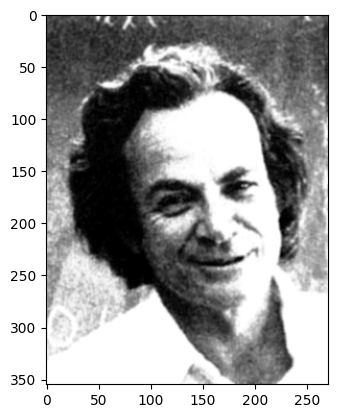

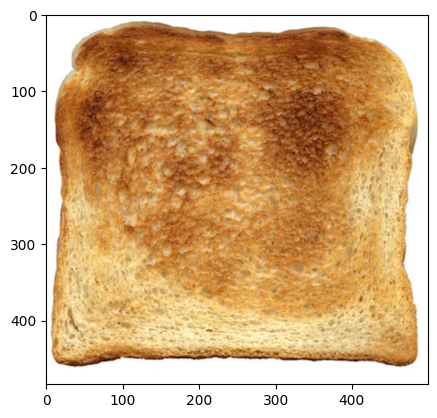

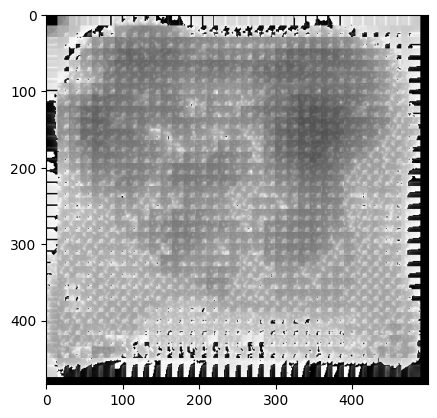

In [143]:
texture_img_fn = "samples/feynman.tiff"
guidance_img_fn = "samples/toast.jpg"
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
patch_size = 25
overlap = 10
tol = 0.01
alpha = 0.2
res = texture_transfer2(texture_img, patch_size, overlap, tol, guidance_img, alpha)
res = res.astype(np.uint8)
plt.imshow(res)
plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).